# Introduction

The codes in this notebook are reproducable !!!
The cell containing the imports needs to run first. Then, any of the can be run in any order.

In [1]:
import os
import sys
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.ticker import LinearLocator, FormatStrFormatter 
import numpy as np 
from random import random, seed
import functions as fx
import sklearn.model_selection as sklm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from imageio import imread

# Franke function and digital tarrain data (generate, read, and plot)

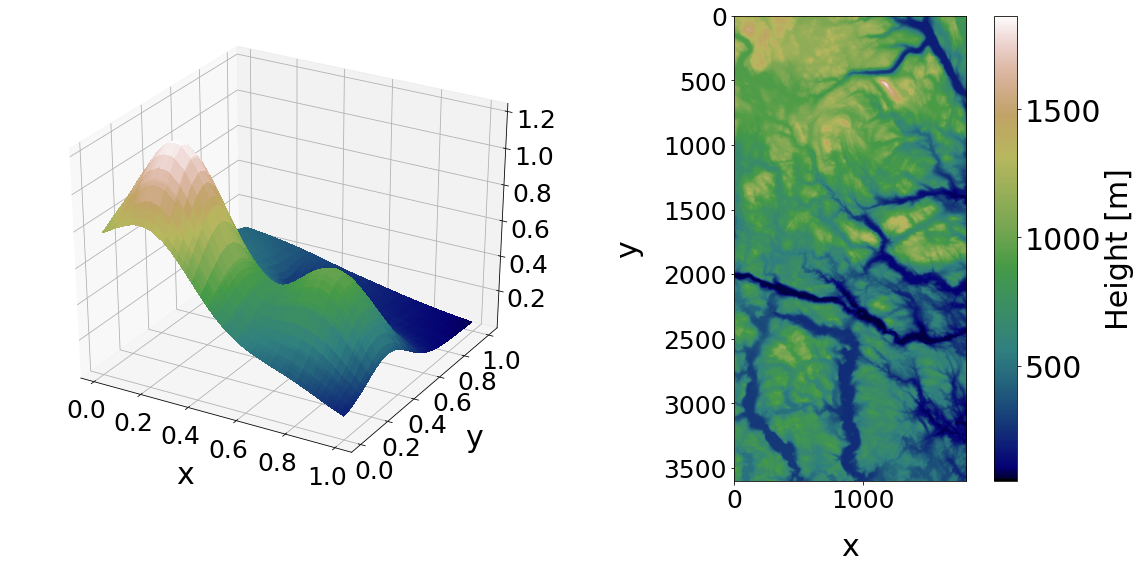

In [3]:
# Make data using rand function
n_x = 100
np.random.seed(2020)
x   = np.sort(np.random.uniform(0, 1, n_x))
y   = np.sort(np.random.uniform(0, 1, n_x))

# Meshgrid x and y to create a surface
xx, yy = np.meshgrid(x,y)

# Generate the Franke function
noise_sigma = 0.00
zz          = fx.FrankeFunction(xx, yy, noise_sigma)
z           = np.ravel(zz)

# Load the terrain data
zi = imread('SRTM_data_Norway_1.tif')

#-------------------- Plot the two dataset------------------------------------------------

fig  = plt.figure(figsize=(16, 8))
ax   = fig.add_subplot(1, 2, 1,projection='3d')
surf = ax.plot_surface(xx, yy, zz, cmap='gist_earth',antialiased=False)
ax.tick_params(axis='x', which='major', labelsize=25,pad=5)
ax.tick_params(axis='y', which='major', labelsize=25,pad=5)
ax.tick_params(axis='z', which='major', labelsize=25,pad=10)
plt.xlabel('x', fontsize = 30,labelpad=25)
plt.ylabel('y', fontsize = 30,labelpad=25)
fig.tight_layout()

ax   = fig.add_subplot(1, 2, 2)
surf = ax.imshow(zi, cmap='gist_earth')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('x', fontsize = 30,labelpad=20)
plt.ylabel('y', fontsize = 30,labelpad=20)
cbar=fig.colorbar(surf)
cbar.ax.set_ylabel('Height [m]', fontsize = 30)
cbar.ax.tick_params(labelsize=30)
fig.tight_layout()
plt.show()


## Ordinary Least Square (OLS) on the Franke function

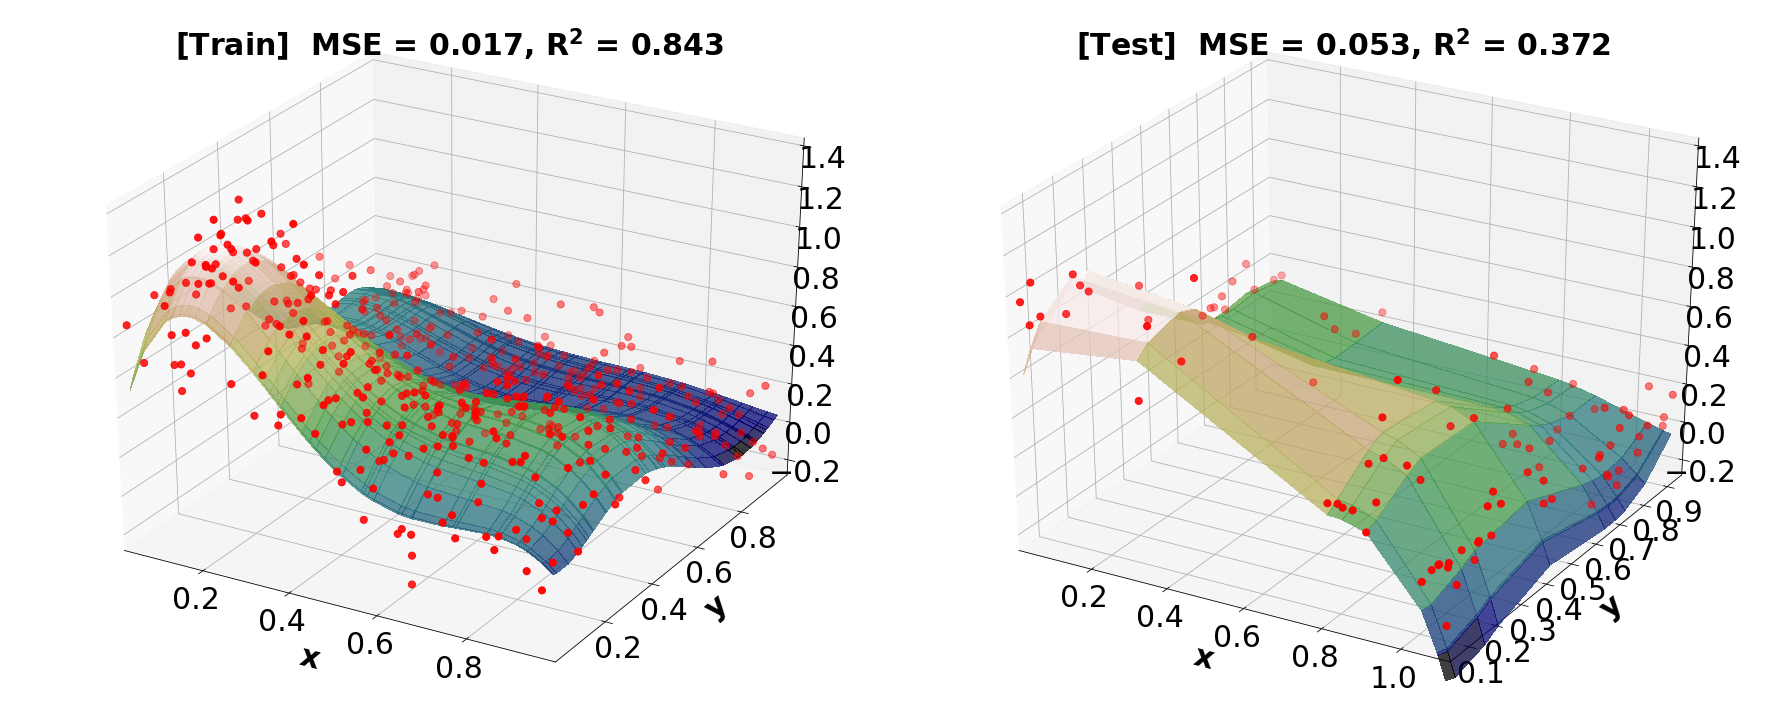

In [7]:
# polynomial degree and number of data samples
degree    = 5              
l         = int((degree+1)*(degree+2)/2)
n_samp    = int((2*l)/0.8)
np.random.seed(2020)

# Generate uniformly random samples between 0 and 1
x  = np.random.uniform(0, 1, n_samp)
y  = np.random.uniform(0, 1, n_samp)
x1 = np.random.uniform(0, 1.2, n_samp)
y1 = np.random.uniform(0, 1, n_samp)

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

# Creating design matrix, extracting beta and predicting 
X_train = fx.DesignDesign(x_train,y_train,degree)  
X_test  = fx.DesignDesign(x_test,y_test,degree)  

## Scaling the design matrix
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]
    
# OLS (Training and prediction) 
beta_OLS, pred_OLS_test, pred_OLS_train = fx.OridinaryLeastSquares(X_train,z_train,X_test) 

# MSE and R2
MSE_OLS_test  = fx.MSE(z_test,pred_OLS_test)
MSE_OLS_train = fx.MSE(z_train,pred_OLS_train)
R2_OLS_test   = fx.R2Score(z_test,pred_OLS_test)
R2_OLS_train  = fx.R2Score(z_train,pred_OLS_train)
        
# reshape the data for surface plotting
ppred_OLS_test  = pred_OLS_test.reshape(xx_test.shape)
ppred_OLS_train = pred_OLS_train.reshape(xx_train.shape)

#-------------------------------------Plot the results---------------------------------------------------------------

fig = plt.figure(figsize=(25, 10))
ax  = fig.add_subplot(1, 2, 1, projection='3d')
CS  = ax.plot_surface(xx_train, yy_train, ppred_OLS_train, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
figure1 = ax.scatter(xx_train[0::int(n_train*0.1)], yy_train[0::int(n_train*0.1)], zz_train[0::int(n_train*0.1)], 
           marker='.', s=200, c="red")
ax.set_zlim3d(np.min(z_train), np.max(z_train))
ax.set_ylim3d(np.min(y_train), np.max(y_train))
ax.set_xlim3d(np.min(x_train), np.max(x_train))
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Train] " + " MSE = %0.3f" %MSE_OLS_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_OLS_train, fontsize = 30, fontweight='bold')
fig.tight_layout()

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.set_zlim3d(np.min(z_train), np.max(z_train))
ax1.set_ylim3d(np.min(y_test), np.max(y_test))
ax1.set_xlim3d(np.min(x_test), np.max(x_test))
CS = ax1.plot_surface(xx_test, yy_test, ppred_OLS_test, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
ax1.scatter(xx_test[0::int(n_test*0.1)], yy_test[0::int(n_test*0.1)], zz_test[0::int(n_test*0.1)], 
           marker='.', s=200, c="red")
ax1.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Test] " + " MSE = %0.3f" %MSE_OLS_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_OLS_test, fontsize = 30, fontweight='bold')
fig.tight_layout()
plt.show()

# Ridge Regression on the Franke function

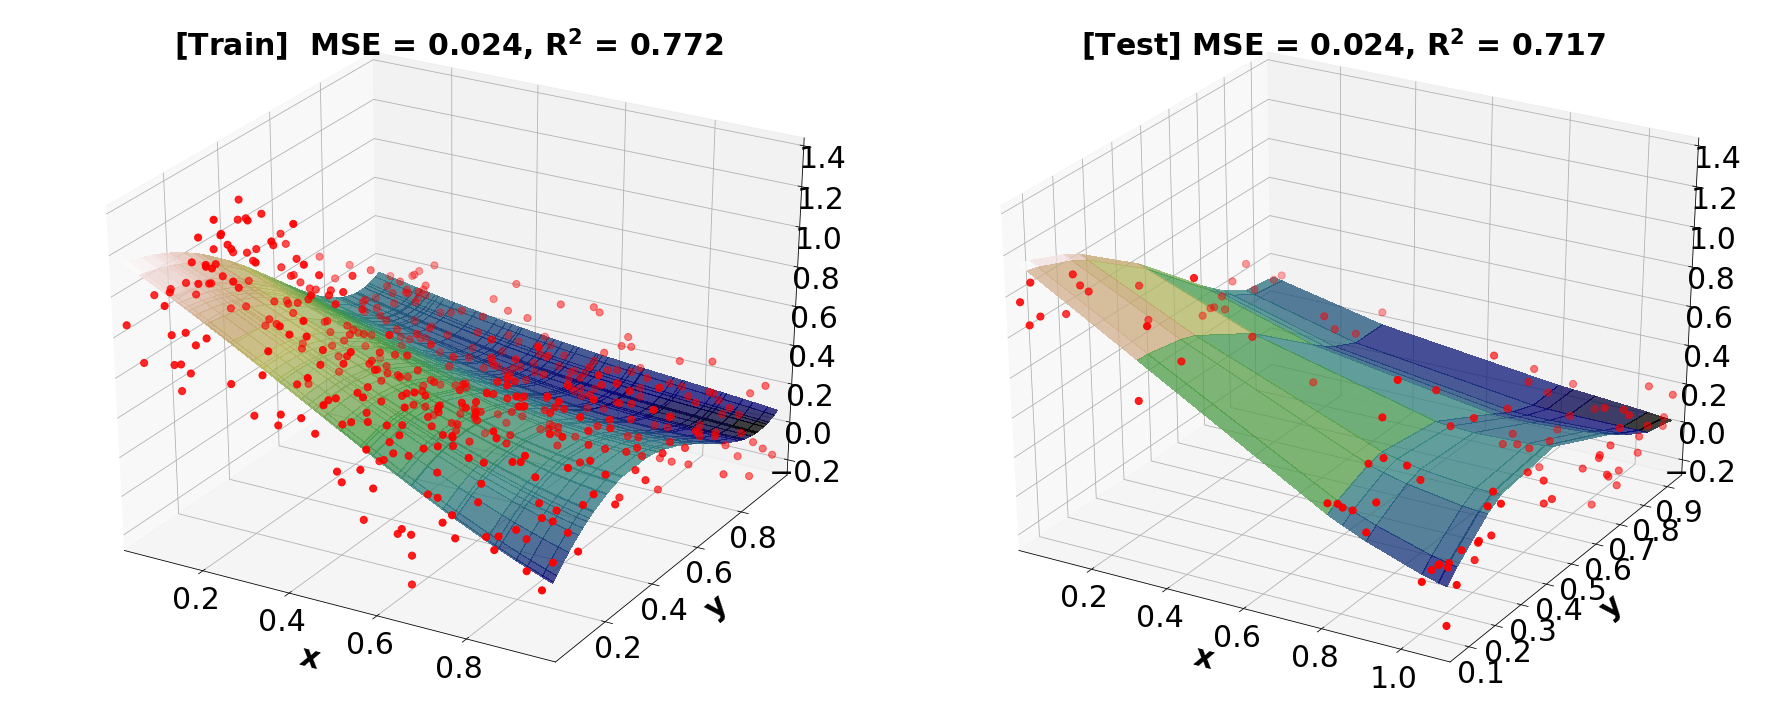

In [6]:
# polynomial degree and number of data samples
degree    = 5              
l         = int((degree+1)*(degree+2)/2)
n_samp    = int((2*l)/0.8)
np.random.seed(2020)

# Generate uniformly random samples between 0 and 1
x  = np.random.uniform(0, 1, n_samp)
y  = np.random.uniform(0, 1, n_samp)
x1 = np.random.uniform(0, 1.2, n_samp)
y1 = np.random.uniform(0, 1, n_samp)

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

# Creating design matrix, extracting beta and predicting 
X_train = fx.DesignDesign(x_train,y_train,degree)  
X_test  = fx.DesignDesign(x_test,y_test,degree)  

## Scaling the design matrix
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# Hyper-parameter
_lambda = 1e1

# Ridge regression (Training and prediction) 
beta_Ridge, pred_Ridge_test, pred_Ridge_train = fx.RidgeRegression(X_train,z_train,X_test,_lambda)

# MSE and R2
MSE_Ridge_test  = fx.MSE(z_test,pred_Ridge_test)
MSE_Ridge_train = fx.MSE(z_train,pred_Ridge_train)
R2_Ridge_test   = fx.R2Score(z_test,pred_Ridge_test)
R2_Ridge_train  = fx.R2Score(z_train,pred_Ridge_train)
        
# reshape the data for surface plotting
ppred_Ridge_test  = pred_Ridge_test.reshape(xx_test.shape)
ppred_Ridge_train = pred_Ridge_train.reshape(xx_train.shape)

#---------------------------------------Plot the results---------------------------------------------------------------

fig = plt.figure(figsize=(25, 10))
ax  = fig.add_subplot(1, 2, 1, projection='3d')
CS  = ax.plot_surface(xx_train, yy_train, ppred_Ridge_train, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
figure1 = ax.scatter(xx_train[0::int(n_train*0.1)], yy_train[0::int(n_train*0.1)], zz_train[0::int(n_train*0.1)], 
           marker='.', s=200, c="red")
ax.set_zlim3d(np.min(z_train), np.max(z_train))
ax.set_ylim3d(np.min(y_train), np.max(y_train))
ax.set_xlim3d(np.min(x_train), np.max(x_train))
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Train] " + " MSE = %0.3f" %MSE_Ridge_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_Ridge_train, fontsize = 30, fontweight='bold')
fig.tight_layout()

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.set_zlim3d(np.min(z_train), np.max(z_train))
ax1.set_ylim3d(np.min(y_test), np.max(y_test))
ax1.set_xlim3d(np.min(x_test), np.max(x_test))
CS = ax1.plot_surface(xx_test, yy_test, ppred_Ridge_test, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
ax1.scatter(xx_test[0::int(n_test*0.1)], yy_test[0::int(n_test*0.1)], zz_test[0::int(n_test*0.1)], 
           marker='.', s=200, c="red")
ax1.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Test] " + "MSE = %0.3f" %MSE_Ridge_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_Ridge_test, fontsize = 30, fontweight='bold')
fig.tight_layout()
plt.show()

# LASSO Regression on the Franke function

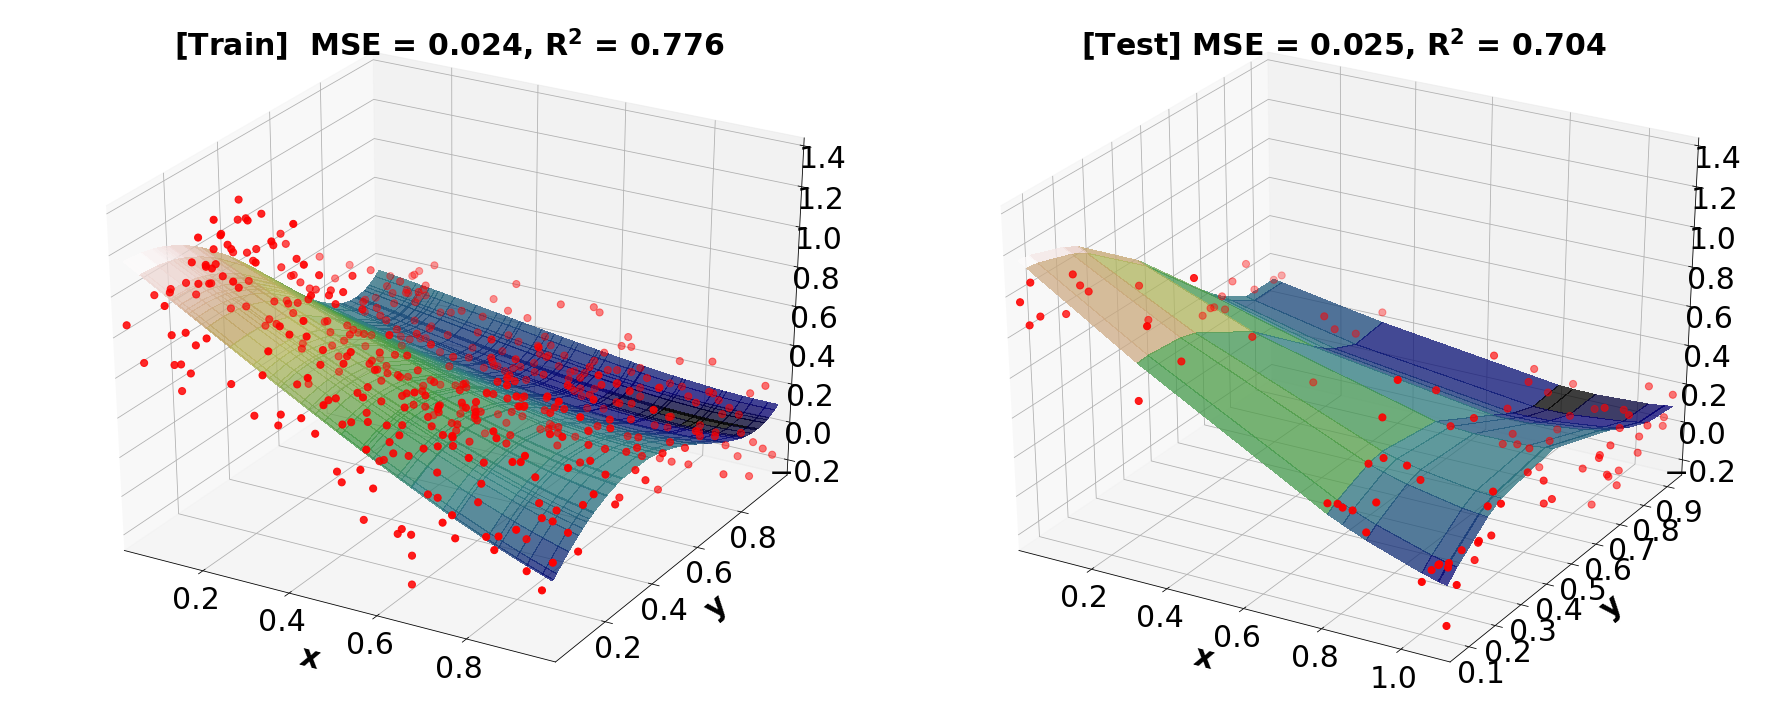

In [9]:
# polynomial degree and number of data samples
degree    = 5              
l         = int((degree+1)*(degree+2)/2)
n_samp    = int((2*l)/0.8)
np.random.seed(2020)

# Generate uniformly random samples between 0 and 1
x  = np.random.uniform(0, 1, n_samp)
y  = np.random.uniform(0, 1, n_samp)
x1 = np.random.uniform(0, 1.2, n_samp)
y1 = np.random.uniform(0, 1, n_samp)

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

# Generate noise and add it to Franke function
zz_0     = fx.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = fx.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = fx.FrankeFunction(xx_test, yy_test, nsig)
z_train  = np.ravel(zz_train)
z_test   = np.ravel(zz_test)

# Creating design matrix, extracting beta and predicting 
X_train = fx.DesignDesign(x_train,y_train,degree)  
X_test  = fx.DesignDesign(x_test,y_test,degree)  

## Scaling the design matrix
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# Hyper-parameter
_lambda = 1e-3
    
# LASSO (Training) 
lasso      = Lasso(alpha = _lambda, max_iter=10e5,fit_intercept=True, tol=1e-6)
clf_lasso  = lasso.fit(X_train, z_train) 
beta_LASSO = clf_lasso.coef_
beta_LASSO = beta_LASSO.reshape(X_train.shape[1],1)

# LASSO (prediction) 
pred_LASSO_test  = lasso.predict(X_test)
pred_LASSO_train = lasso.predict(X_train)
    
# MSE and R2
MSE_LASSO_test  = fx.MSE(z_test,pred_LASSO_test)
MSE_LASSO_train = fx.MSE(z_train,pred_LASSO_train)
R2_LASSO_test   = fx.R2Score(z_test,pred_LASSO_test)
R2_LASSO_train  = fx.R2Score(z_train,pred_LASSO_train)
        
# reshape the data for surface plotting
ppred_LASSO_test  = pred_LASSO_test.reshape(xx_test.shape)
ppred_LASSO_train = pred_LASSO_train.reshape(xx_train.shape)

#-----------------------------------Plot the results-----------------------------------------------------------

fig = plt.figure(figsize=(25, 10))
ax  = fig.add_subplot(1, 2, 1, projection='3d')
CS  = ax.plot_surface(xx_train, yy_train, ppred_LASSO_train, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
figure1 = ax.scatter(xx_train[0::int(n_train*0.1)], yy_train[0::int(n_train*0.1)], zz_train[0::int(n_train*0.1)], 
           marker='.', s=200, c="red")
ax.set_zlim3d(np.min(z_train), np.max(z_train))
ax.set_ylim3d(np.min(y_train), np.max(y_train))
ax.set_xlim3d(np.min(x_train), np.max(x_train))
ax.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Train] " + " MSE = %0.3f" %MSE_LASSO_train + 
          r", $\bf{R^2}$ = %0.3f"%R2_LASSO_train, fontsize = 30, fontweight='bold')
fig.tight_layout()

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.set_zlim3d(np.min(z_train), np.max(z_train))
ax1.set_ylim3d(np.min(y_test), np.max(y_test))
ax1.set_xlim3d(np.min(x_test), np.max(x_test))
CS = ax1.plot_surface(xx_test, yy_test, ppred_LASSO_test, cmap='gist_earth',linewidth=0, antialiased=False, alpha=0.75)
ax1.scatter(xx_test[0::int(n_test*0.1)], yy_test[0::int(n_test*0.1)], zz_test[0::int(n_test*0.1)], 
           marker='.', s=200, c="red")
ax1.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$\bf{x}$', fontsize = 30,labelpad=20)
plt.ylabel(r'$\bf{y}$', fontsize = 30,labelpad=20)
plt.title("[Test] " + "MSE = %0.3f" %MSE_LASSO_test + 
          r", $\bf{R^2}$ = %0.3f"%R2_LASSO_test, fontsize = 30, fontweight='bold')
fig.tight_layout()
plt.show()

# Bias-variance trade-off (OLS)

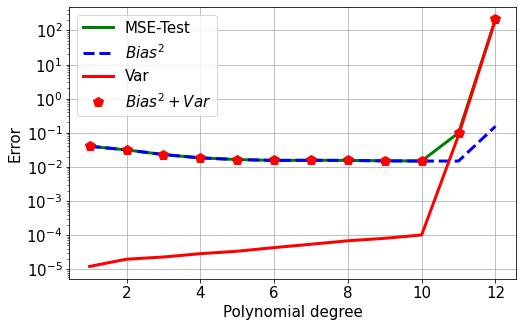

In [63]:
# Maximum polynomial order for generating the design matrix
maxdegree = 12              
maxind    = int(maxdegree*1) 
l         = int((maxind+1)*(maxind+2)/2)
n_samp    = int((1*l)/0.8)

# Make data using rand function
np.random.seed(2020)
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))

# Meshgrid x and y to create a surface
xx, yy = np.meshgrid(x,y)

# Generate noise and add it to Franke function
zz_0 = fx.FrankeFunction(xx, yy, 0)
nsig = 0.1*np.max(np.abs(zz_0))
zz   = fx.FrankeFunction(xx, yy, nsig)
z    = np.ravel(zz)

# Number of bootstraps and array of poly. degrees
n_boostraps = int(10*n_samp)                                  
degrees     = np.arange(1,maxdegree+1)

# Pre-allocate 
err1   = []
errt1  = []
bi1    = []
vari1  = []

# Define the scaling method
scaler = StandardScaler()

# Running loop over model complexity 
for i in range(maxdegree):
    
    # Creating design matrix
    X = fx.DesignDesign(x,y,i+1)  

    # split in training and test data
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
    
    # Select out the column containing the intercept
    X_test_int = X_test[:,0]
    X_test     = X_test[:,1:]

    z_test   = z_test.reshape(z_test.shape[0],1)
    z_pred   = np.empty((z_test.shape[0], n_boostraps))
    z_predt  = np.empty((z_train.shape[0], n_boostraps))
    z_train2 = np.empty((z_train.shape[0], n_boostraps))
    
    for i in range(n_boostraps):
        
        X_, z_         = resample(X_train, z_train)
        z_train2[:, i] = z_
        
        # Scaling
        X_int = X_[:,0]
        X_    = X_[:,1:]
        scaler.fit(X_)
        X_      = scaler.transform(X_)
        X_test2 = scaler.transform(X_test)
        X_      = np.c_[X_int,X_]
        X_test2 = np.c_[X_test_int,X_test2]
        
        # Evaluate the new model on the same test data each time.
        _, z_pred[:, i], z_predt[:, i] = fx.OridinaryLeastSquares(X_,z_,X_test2)
    
    errorin  = np.mean(np.mean((z_train2 - z_predt)**2, axis=1, keepdims=True))
    error    = np.mean(np.mean((z_test - z_pred)**2, axis=1, keepdims=True))
    bias     = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance = np.mean(np.var(z_pred, axis=1, keepdims=True))
    
    err1.append(error)
    errt1.append(errorin)
    bi1.append(bias)
    vari1.append(variance)
    
#-----------------------------------Plot the results-----------------------------------------------------------

fig, ax = plt.subplots(figsize=(8,5))   
plt.semilogy(degrees[:maxdegree],err1[:maxdegree],'g',linewidth=3,label='MSE-Test')
#plt.semilogy(degrees[:maxdegree],errt1[:maxdegree],'k--',linewidth=3,label='MSE-Train')
plt.semilogy(degrees[:maxdegree],bi1[:maxdegree],'--b',linewidth=3,label='$Bias^2$')
plt.semilogy(degrees[:maxdegree],vari1[:maxdegree],'-r',linewidth=3,label='Var')
summ1 = np.zeros(len(vari1))
for i in range(len(err1)):
    summ1[i] = vari1[i] + bi1[i]    
plt.semilogy(degrees[:maxdegree],summ1[:maxdegree],'rp',label='$Bias^2 + Var$',markersize=10)
plt.xlabel('Polynomial degree', fontsize = 15)
plt.ylabel('Error', fontsize = 15)
plt.legend()
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='upper left',fontsize=15)
plt.show()

# In-sample and out-off-sample errors as a function of training size (OLS)

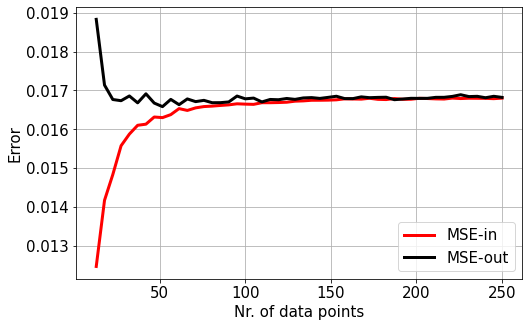

In [48]:
# Maximum polynomial order and the number of samples
maxdegree = 5               
l         = int((maxdegree+1)*(maxdegree+2)/2)
n_samp    = int((0.5*l)/0.8)

# Number trails of generating the Franke function and evaluating in- and out-of-sample errors
N     = np.linspace(n_samp,250,50)
Ndiv  = 100

# Make data using rand function
np.random.seed(2020)
scaler = StandardScaler()

# Pre-allocate 
mse_in  = np.empty(len(N))
mse_out = np.empty(len(N))
J       = 0

for ii in N:

    errinx  = 0
    erroutx = 0
    
    for mm in range(Ndiv):
        
        np.random.seed(2020+mm)
        x = np.sort(np.random.uniform(0, 1, int(ii)))
        y = np.sort(np.random.uniform(0, 1, int(ii)))
        xx, yy = np.meshgrid(x,y)

        # Generate noise and add it to Franke function
        zz_0 = fx.FrankeFunction(xx, yy, 0)
        nsig = 0.1*np.max(np.abs(zz_0))
        zz   = fx.FrankeFunction(xx, yy, nsig)
        z    = np.ravel(zz)

        # Creating design matrix
        X = fx.DesignDesign(x,y,maxdegree)  
        x_train, x_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
        
        # Scaling
        x_train_int = x_train[:,0]
        x_test_int  = x_test[:,0]
        x_train     = x_train[:,1:]
        x_test      = x_test[:,1:]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test  = scaler.transform(x_test)
        x_train = np.c_[x_train_int,x_train]
        x_test  = np.c_[x_test_int,x_test]
        
        # OLS
        _, predict, predict_train = fx.OridinaryLeastSquares(x_train,z_train,x_test)
    
        errin  = fx.MSE(z_train, predict_train)
        errout = fx.MSE(z_test, predict)
            
        errinx  += errin
        erroutx += errout
    
    mse_in[J]  = errinx/Ndiv
    mse_out[J] = erroutx/Ndiv
    J          += 1
    
# ----------------------------- Plotting ---------------------

fig, ax = plt.subplots(figsize=(8,5))   
plt.plot(N,mse_in,'r',linewidth=3,label='MSE-in')
plt.plot(N,mse_out,'k',linewidth=3,label='MSE-out')
plt.xlabel('Nr. of data points', fontsize = 15)
plt.ylabel('Error', fontsize = 15)
plt.legend()
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(loc='lower right',fontsize=15)
plt.show()

# Model Selection by K-fold Cross Validation (OLS)

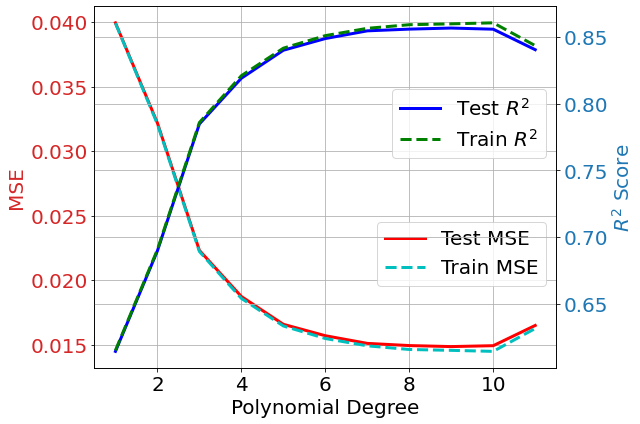

In [70]:
# Maximum polynomial order and K-fold
maxpower = 11
k        = 5

# Generate uniformly random data points
np.random.seed(2020)
n_samp = 1*int((maxpower+1)*(maxpower+2)/2)  
x      = np.sort(np.random.uniform(0, 1, n_samp))
y      = np.sort(np.random.uniform(0, 1, n_samp))

# Meshgrid x and y to create a surface
xx, yy = np.meshgrid(x,y)

# Generate noise and add it to Franke function
zz_0 = fx.FrankeFunction(xx, yy, 0)
nsig = 0.1*np.max(np.abs(zz_0))
zz   = fx.FrankeFunction(xx, yy, nsig)
z    = np.ravel(zz)

# pre-allocate 
r2_out_ols   = np.zeros(maxpower)
r2_in_ols    = np.zeros(maxpower)
mse_out_ols  = np.zeros(maxpower)
mse_in_ols   = np.zeros(maxpower)
scaler       = StandardScaler()

for i in range(maxpower):
    
    X = fx.DesignDesign(x,y,i+1)
    
    ## Scaling
    X_int = X[:,0]
    X     = X[:,1:]
    scaler.fit(X)
    X = scaler.transform(X)
    X = np.c_[X_int,X]
    
    r2_out_ols[i], mse_out_ols[i], r2_in_ols[i], mse_in_ols[i] \
                    = fx.k_fold_cv(k, z, X, fx.OridinaryLeastSquares, shuffle=True)

# ----------------------------- Plotting ----------------------------------------------

fig, ax1 = plt.subplots(figsize=(9,6))
color    = 'tab:red'
ax1.set_xlabel('Polynomial Degree',fontsize=20)
ax1.set_ylabel('MSE',fontsize=20, color=color)
ax1.plot(range(1,maxpower+1), (mse_out_ols), 'r',linewidth=3, label='Test MSE')
ax1.plot(range(1,maxpower+1), (mse_in_ols), 'c',linewidth=3,linestyle='--', label='Train MSE')
ax1.legend(loc='lower right', bbox_to_anchor=(1, 0.2),fontsize=20)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.grid()

ax2   = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('$R^2$ Score',fontsize=20, color=color) 
ax2.plot(range(1,maxpower+1), (r2_out_ols),'b',linewidth=3, label=r'Test $R^2$')
ax2.plot(range(1,maxpower+1), (r2_in_ols),'g',linewidth=3, linestyle='--',label=r'Train $R^2$')
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.8),fontsize=20)
plt.grid()
fig.tight_layout()  
plt.show()